In [150]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer


In [151]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [152]:
data=pd.read_csv("housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [153]:
#performing EDA
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [154]:
#Check for the Null Values
data.isnull().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [155]:
#subsituting the null values with zeros
data=data.fillna(0)

In [156]:
data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [157]:
#this is the Y, log the median hoouse value
data['median_house_value']=np.log1p(data['median_house_value'])

In [158]:
#splitting the value
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [159]:
#Seperating X and Y
Y_train=df_train['median_house_value']
del df_train['median_house_value']
Y_train

9107     12.337544
13999    10.915107
5610     12.069686
13533    11.694422
2953     11.055656
           ...    
4482     11.831386
1835     12.288578
8539     12.273736
2155     10.987003
13351    12.181273
Name: median_house_value, Length: 12384, dtype: float64

In [160]:
Y_val=df_val['median_house_value']
del df_val['median_house_value']

In [161]:
Y_test=df_test['median_house_value']
del df_test['median_house_value']

In [162]:
df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4712,-118.36,34.06,39.0,2810.0,670.0,1109.0,624.0,3.2500,<1H OCEAN
2151,-119.78,36.78,37.0,2185.0,455.0,1143.0,438.0,1.9784,INLAND
15927,-122.42,37.73,46.0,1819.0,411.0,1534.0,406.0,4.0132,NEAR BAY
82,-122.28,37.81,52.0,340.0,97.0,200.0,87.0,1.5208,NEAR BAY
8161,-118.13,33.82,37.0,1530.0,290.0,711.0,283.0,5.1795,<1H OCEAN


In [163]:
#Apply a eictorizer
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [164]:
#Train a Tree and a random forest, first with max_depth=1
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
dt = DecisionTreeRegressor(max_depth=1)
X_train.shape

(12384, 13)

In [165]:
dt.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=1)

In [166]:
#seeing hiow the tree works
from sklearn.tree import export_text

In [167]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [168]:
#applying a random forest
rf = RandomForestRegressor(n_estimators=10,n_jobs=-1,random_state=1)
rf.fit(X_train,Y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [169]:
#testing on the validation data
val_dicts= df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [170]:
#calculating the rmse error
Y=rf.predict(X_val)
error=rmse(Y_val,Y)

In [171]:
error

0.24573834331838432

In [173]:
#tuning the n_estimator parameter
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_val)
    error = rmse(Y_val, y_pred)
    scores.append((n, error))
    print(n)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


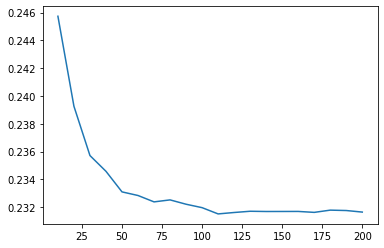

In [177]:
#seeing the plateau
import matplotlib.pyplot as plt
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [179]:
#tuning rhe n_estimators and max depth
scores = []
parameters=[]
for s in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,max_depth=s,random_state=1)
        rf.fit(X_train, Y_train)
        y_pred = rf.predict(X_val)
        error= rmse(Y_val, y_pred)
        parameters.append((s, n))
        scores.append(error)
        print((s,n))
        

(10, 10)
(10, 20)
(10, 30)
(10, 40)
(10, 50)
(10, 60)
(10, 70)
(10, 80)
(10, 90)
(10, 100)
(10, 110)
(10, 120)
(10, 130)
(10, 140)
(10, 150)
(10, 160)
(10, 170)
(10, 180)
(10, 190)
(10, 200)
(15, 10)
(15, 20)
(15, 30)
(15, 40)
(15, 50)
(15, 60)
(15, 70)
(15, 80)
(15, 90)
(15, 100)
(15, 110)
(15, 120)
(15, 130)
(15, 140)
(15, 150)
(15, 160)
(15, 170)
(15, 180)
(15, 190)
(15, 200)
(20, 10)
(20, 20)
(20, 30)
(20, 40)
(20, 50)
(20, 60)
(20, 70)
(20, 80)
(20, 90)
(20, 100)
(20, 110)
(20, 120)
(20, 130)
(20, 140)
(20, 150)
(20, 160)
(20, 170)
(20, 180)
(20, 190)
(20, 200)
(25, 10)
(25, 20)
(25, 30)
(25, 40)
(25, 50)
(25, 60)
(25, 70)
(25, 80)
(25, 90)
(25, 100)
(25, 110)
(25, 120)
(25, 130)
(25, 140)
(25, 150)
(25, 160)
(25, 170)
(25, 180)
(25, 190)
(25, 200)


In [180]:
#Computing the value of minimum errorr
print(scores.index(min(scores)))

70


In [181]:
#a mximum depth of 25 and n estimators of 110 are needed
parameters[70]

(25, 110)

In [184]:
#Defining the most important feartures
rf = RandomForestRegressor(n_estimators=10,max_depth=20,n_jobs=-1,random_state=1)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [200]:
#Determing the features with the highest score
feature_import=rf.feature_importances_
ingg=np.where(feature_import==(max(feature_import)))
ingg

(array([4], dtype=int64),)

In [195]:
features = dv.get_feature_names()
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [201]:
features[4]

'median_income'

In [202]:
#Training XCBOOst , then calculating the error on the validation set
import xgboost as xgb
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=Y_train)
#dval = xgb.DMatrix(X_val, label=Y_val, feature_names=features)
dval = xgb.DMatrix(X_val, label=Y_val)

In [192]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [204]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [205]:
Y_predict=model.predict(dval)

In [207]:
error_three=rmse(Y_val,Y_predict)
error

0.2314923179801403

In [208]:
#changing the eta value and calculating the error which remains the same
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [209]:
Y_predict=model.predict(dval)
error_three=rmse(Y_val,Y_predict)
error

0.2314923179801403